In [2]:
import cProfile
import os
import statistics as st
import plotly.graph_objects as go
import random as rd
import time
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import itertools as it
import Utilities.experiment_utils as eu
import unit_test as ut
import Games.mnk as mnk
import Games.Carcassonne.Carcassonne as carc
import Games.carcassonne_oldtry as csn_old
#import Games.carcassonne_older as csn
import Agents.random as arand
import Agents.vanilla_mcts as mcts
import Agents.siea_mcts as siea_mcts
import Agents.siea_mcts2 as siea2
import Agents.mcts_rave as rave_mcts
import Agents.one_step_lookahead as osla
import Agents.mcts_solver as mcts_solver
import Games.function_optimisation as fo
import Utilities.logs_management as lm
import Games.chess_64 as chess_64
import chess as chess
import chess.svg
import matplotlib.pyplot as plt
import shutil
import itertools
from IPython.display import display
import ast
from IPython.display import Image
import datetime
import multiprocessing as mp
from plotly.subplots import make_subplots
from IPython.display import HTML

#cProfile.run("wins =  random_games(10000, base_gs)")
#ut.run()

import scipy.stats

def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)
#https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments
#https://stackoverflow.com/questions/40294844/calculate-t-student-test-for-the-next-table-in-python
#https://www.geeksforgeeks.org/python-students-t-distribution-in-statistics/
#https://itl.nist.gov/div898/handbook/eda/section3/eda352.htm
#https://docs.tibco.com/data-science/GUID-8E64444A-5F5B-49F9-A43A-74B13647AFB4.html#:~:text=The%20larger%20the%20variation%2C%20the%20less%20reliable%20the,sample%20size%20is%20large%2C%20say%20n%3D100%20or%20more.

def display_color_palette(palette):
    # Create a style string for each color in the palette
    style_blocks = [f'<div style="width: 50px; height: 50px; display: inline-block; background: {color};"></div>' for color in palette]
    
    # Join the style blocks and wrap them in a div
    display_html = '<div>' + ''.join(style_blocks) + '</div>'

    # Display the HTML in the Jupyter Notebook
    display(HTML(display_html))

c:\Users\Fredasus\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Fredasus\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


CARC DEVALUE ANALYSIS

In [19]:
#PARAMETERS
#logs_path = os.path.join("Outputs", "Carcassonne_analysis", "meeples 7_games 1000_seed 0_fulltiles True_deterministic False")# This exp is ok
logs_path = os.path.join("Outputs", "Carcassonne_analysis", "meeples 3_games 1000_seed 0_fulltiles False_deterministic False")# This exp is ok
#logs_path = os.path.join("Outputs", "Carcassonne_analysis", "FINAL_meeples7_games100_seed0_fulltilesTrue_deterministicFalse_players22nd_turn_after_tile13")
colors = ["#5B8C5A","#56638A","#EC7316","#e265ef","#c27dd1","#d52e87","#a8d0b9","#ad8dfd"]
replaces = {"(1,0)":"Top", "(0,1)":"Right", "(-1,0)":"Bottom", "(0,-1)":"Left"}

In [22]:
#Count actions

#paramters:
full_tiles = False
deterministic = False
game_seed = 0
meeples = 3
players = 1
devalue_games = 100
second_turn = False
enforced_fist_turn_tile = 0

if full_tiles:
    initial_tile_quantities = [1,3,1,1,2,3,2,2,2,3,1,3,2,5,3,2,4,3,3,4,4,9,8,1]
else:
    initial_tile_quantities = [1 for _ in range(24)]

game_state = carc.CarcassonneState(name = "Carcassonne",
                                                initial_tile_quantities = initial_tile_quantities,
                                                set_tile_sequence= deterministic,
                                                set_tile_sequence_seed=game_seed,
                                                initial_meeples = [meeples, meeples],
                                                players = players)
game_state.set_initial_state()

if second_turn:
    game_state.sample_random_event(event_type = "Draw random tile", enforced_outcome = enforced_fist_turn_tile)

    if enforced_fist_turn_tile == 13:
        #find and play action that closes the initial city
        for action in game_state.available_actions:
            fclone_state = game_state.duplicate()
            fclone_state.make_action(action)
            if fclone_state.Scores[0] == 4:
                print("winning action", action)
                break
    else:
        for action in game_state.available_actions:
            fclone_state = game_state.duplicate()
            fclone_state.make_action(action)
            if fclone_state.Scores[2] == 0:
                print("winning action", action)
                break
    
    game_state = fclone_state   

#Initialise agent: 
action_counts = []
for tile_index, tile_quantity in enumerate(game_state.TileQuantities):
    if tile_quantity > 0 and tile_index != 0: #REMOVE TILE INDEX CONDITION, ONLY HERE FOR THE SECOND MOVE IF NO CITIES ARE AVAILABLE
        game_state.sample_random_event(event_type = "Draw random tile", enforced_outcome = tile_index)
        action_counts.append(len(game_state.available_actions))
#print mean
print("mean", st.mean(action_counts), "+-", st.stdev(action_counts))
#print total
print("total", sum(action_counts))
#print max score
print(game_state.max_score(verbose=True))

mean 20.545454545454547 +- 13.312104311945621
total 452
City points:  52
Road points:  20
Monastery points:  18
Closed cities:  5
Farm points:  45
Max score: 135
135


In [15]:
#Aux data because of error not including the full action. Now added in the code, but still need to run this to fix the old data
full_tiles = False
game_seed = 0

#calculations
if full_tiles:
    initial_tile_quantities = [1,3,1,1,2,3,2,2,2,3,1,3,2,5,3,2,4,3,3,4,4,9,8,1]
else:
    initial_tile_quantities = [1 for _ in range(24)]

#Initialise carcassonne game
game_state = carc.CarcassonneState(name = "dummy",
                                                initial_tile_quantities = initial_tile_quantities,
                                                set_tile_sequence= False,
                                                set_tile_sequence_seed=game_seed,
                                                initial_meeples = [1, 1],
                                                players = 2)
game_state.set_initial_state()

actions_dict = {"action":[],"First_move_tile_index":[], "First_move_action_index":[], "tile_location":[], "tile_rotation":[], "tile_probability":[]}
for tile_index, tile_quantity in enumerate(game_state.TileQuantities):
    if tile_quantity > 0:
        game_state.sample_random_event(event_type = "Draw random tile", enforced_outcome = tile_index)
        for action_index, available_action in enumerate(game_state.available_actions):
            actions_dict["action"].append(str(available_action))
            actions_dict["First_move_tile_index"].append(tile_index)
            actions_dict["First_move_action_index"].append(action_index)
            actions_dict["tile_location"].append(str(available_action).split("(X,Y): ")[1].split(", Rotation: ")[0])
            actions_dict["tile_rotation"].append(str(available_action).split("Rotation: ")[1].split(",")[0])
            actions_dict["tile_probability"].append(game_state.TileQuantities[tile_index]+1/sum(game_state.TileQuantities))
actions_df = pd.DataFrame(actions_dict)
#print(actions_df.head())
cc = lm.dump_data(pd.DataFrame(actions_dict), file_path = logs_path, file_name="actions_dict.csv")

In [16]:
#COLLECT LOGS - Only ran the first time

collective_logs = pd.DataFrame()
collective_action_logs = pd.DataFrame()
#print(os.listdir(output_path))
for tile_index in os.listdir(logs_path):
    #if path is a folder
    if os.path.isdir(os.path.join(logs_path, tile_index)):
        #print(tile_index)
        for action_index in os.listdir(os.path.join(logs_path, tile_index)):
            #print(action_index)
            for meeple_type in os.listdir(os.path.join(logs_path, tile_index, action_index)):
                #print(meeple_type)
                game_log = lm.read_csv(file_path = os.path.join(logs_path, tile_index, action_index, meeple_type, "logs_by_game.csv"))
                action_log = lm.read_csv(file_path = os.path.join(logs_path, tile_index, action_index, meeple_type, "logs_by_action.csv"))
                game_def_data = lm.read_csv(file_path = os.path.join(logs_path, tile_index, action_index, meeple_type, "game_definition_data.csv"))
                game_log["First_move_meeple_type"] = [meeple_type for _ in range(len(game_log))]
                game_log["First_move_tile_index"] = [tile_index.split("_")[1] for _ in range(len(game_log))]
                game_log["First_move_action_index"] = [action_index.split("_")[2] for _ in range(len(game_log))]
                game_log["Max_possible_score"] = [game_def_data["max_possible_score"][0] for _ in range(len(game_log))]
                game_log.replace("Monastery","Cloister")
                collective_logs = pd.concat([collective_logs, game_log], ignore_index = True)
                action_data = pd.merge(action_log[["game_index","Turn","Player_turn","Meeples_on_farms_p1","Meeples_on_farms_p2","Total_played_meeples_p1","Total_played_meeples_p2"]], 
                                       game_log[["game_index","Score_p1","Score_p2","First_move_meeple_type","Winner"]], on = ["game_index"])
                collective_action_logs = pd.concat([collective_action_logs, action_data], ignore_index = True)
cc = lm.dump_data(collective_logs, file_path = logs_path, file_name = "collective_logs.csv")
ca = lm.dump_data(collective_action_logs, file_path = logs_path, file_name = "collective_action_logs.csv")

In [ ]:
#PLOT SCORE DIFF by type of move

#define variables
#weighted = False
x_column = "First_move_meeple_type"
y_columns = ["Score_difference"]#["Score_p1", "Score_p2"]
y_columns2 = ["Score_p1", "Score_p2"]

#Create figure
fig = make_subplots(rows=1
                        ,cols=1
                        ,shared_xaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/2 for _ in range(2)]
                        #,subplot_titles = ["Score difference", "Score"]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Move type"
                        ,y_title='Score'
                        #,print_grid=True
                        )

data = lm.read_csv(file_path = os.path.join(logs_path ,"collective_logs.csv"))
data = data.replace("Monastery","Cloister")
data["Score_difference"] = data["Score_p1"] - data["Score_p2"]



for y_i, y_column in enumerate(y_columns):
    fig.add_trace(go.Box(x=data[x_column]
                        ,y=data[y_column]
                        ,name="Score"
                        , width=0.8
                        #,showlegend=True
                        ,legendgroup=y_i
                        , marker={"color":colors[y_i]}
                        )
                    ,row=1
                    ,col=1)
"""
for y_i, y_column in enumerate(y_columns2):
    fig.add_trace(go.Box(x=data[x_column]
                        ,y=data[y_column]
                        ,name=str(y_column.replace("_", " "))
                        #, width=0.8
                        ,showlegend=True
                        ,legendgroup=y_i + len(y_columns)
                        , marker={"color":colors[y_i + len(y_columns)]}
                        )
                    ,row=2
                    ,col=1)
"""

fig.update_layout(margin=dict(l=60, r=10, t=10, b=80)
                        ,width=500
                        ,height=500
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.16
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    ,tick0 = 0
                    , gridcolor="grey"
                    , gridwidth=1
                    , dtick=10
                    ,showgrid=True
                    ,zerolinecolor = "black"
                    ,zerolinewidth = 1
                    )
fig.write_image(os.path.join(logs_path, "Carcassonne_devalues_by_claimed_feature_t1.png"))
fig.show()

In [ ]:
#Triple dataset comparison
#PLOT SCORE DIFF by type of move
exp_path = os.path.join("Outputs", "Carcassonne_analysis")
dataset_paths = [
   # os.path.join(exp_path, "meeples 7_games 1000_seed 0_fulltiles True_deterministic False"),
    os.path.join(exp_path, "FINAL_meeples7_games100_seed0_fulltilesTrue_deterministicFalse_players22nd_turn_after_tile13"),
    os.path.join(exp_path, "FINAL_meeples7_games100_seed0_fulltilesTrue_deterministicFalse_players22nd_turn_after_tile0")]
dataset_names = [#"First turn", 
                 "B1 : With a completed city", "B2 : With a city less likely to be completed"]
substract_points = [#[0,0],
                    [4,0],[0,0]]
player_perspective = [#0,
                      1,1] #0 means from p1 perspective, 1 from p2 perspective



#define variables
#weighted = False
x_column = "First_move_meeple_type"
y_columns = ["Score_difference"]

#Create figure
fig = make_subplots(rows=1
                        ,cols=1
                        #,shared_xaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/2 for _ in range(2)]
                        #,subplot_titles = ["Score difference", "Score"]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Move type"
                        ,y_title='Score difference'
                        #,print_grid=True
                        )

data = [lm.read_csv(file_path = os.path.join(dataset_path ,"collective_logs.csv")) for dataset_path in dataset_paths]
data = [d.replace("Monastery","Cloister") for d in data]
for di, d in enumerate(data):
    if player_perspective[di] == 0:
        d["Score_difference"] = (d["Score_p1"] - substract_points[di][0]) - (d["Score_p2"] - substract_points[di][1])
    else:
        d["Score_difference"] = (d["Score_p2"] - substract_points[di][1]) - (d["Score_p1"] - substract_points[di][0])


for di, d in enumerate(data):
    for y_i, y_column in enumerate(y_columns):
        fig.add_trace(go.Box(x=d[x_column]
                            ,y=d[y_column]
                            ,name=dataset_names[di]
                            #, width=0.8
                            ,showlegend=True
                            ,legendgroup=di
                            , marker={"color":colors[di]}
                            )
                        ,row=1
                        ,col=1)
"""
for y_i, y_column in enumerate(y_columns2):
    fig.add_trace(go.Box(x=data[x_column]
                        ,y=data[y_column]
                        ,name=str(y_column.replace("_", " "))
                        #, width=0.8
                        ,showlegend=True
                        ,legendgroup=y_i + len(y_columns)
                        , marker={"color":colors[y_i + len(y_columns)]}
                        )
                    ,row=2
                    ,col=1)
"""


fig.update_layout(margin=dict(l=60, r=10, t=10, b=80)
                        ,width=500
                        ,height=500
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.16
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    ,tick0 = 0
                    , gridcolor="grey"
                    , gridwidth=1
                    , dtick=10
                    ,showgrid=True
                    ,zerolinecolor = "black"
                    ,zerolinewidth = 1
                    )
fig.write_image(os.path.join(exp_path, "Carcassonne_devalues_by_claimed_feature_t2.png"))
fig.show()

In [ ]:
#Scores by meeples on farms by turn
x_column = "Turn"
y_columns = ["Meeples_on_farms_p1","Total_played_meeples_p1"]
y_names = ["Meeples on farms", "Meeples on any feature"]

data = lm.read_csv(file_path = os.path.join(logs_path ,"collective_action_logs.csv"))
data = data.replace("Monastery","Cloister")
data["Score_difference"] = data["Score_p1"] - data["Score_p2"]
data["Meeples_on_farms_difference"] = data["Meeples_on_farms_p1"] - data["Meeples_on_farms_p2"]
data["Played_meeples_difference"] = data["Total_played_meeples_p1"] - data["Total_played_meeples_p2"]
#filter
data = data[data["Player_turn"] == 0]

fig = make_subplots(rows=1
                        ,cols=len(y_columns)
                        ,shared_yaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/2 for _ in range(2)]
                        #,subplot_titles = y_columns
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        #,x_title=
                        ,y_title='Turn'
                        #,print_grid=True
                        )
z_mins = []
z_maxs = []
for y_i, y_column in enumerate(y_columns):
    data1 = data[["Turn", y_column,"Score_difference"]]
    grouped_data1 = data1.groupby(["Turn", y_column]).mean()

    lm.dump_data(grouped_data1, file_path = logs_path, file_name = "collective_action_logs_grouped_" + y_column +".csv")
    grouped_data1 = lm.read_csv(file_path = os.path.join(logs_path ,"collective_action_logs_grouped_" + y_column +".csv"))

    turns = sorted(list(set(grouped_data1["Turn"])))
    y_uniques = sorted(list(set(grouped_data1[y_column])))
    print(y_column, y_uniques)
    z = []
    for turn in turns:
        z_row = []
        for y_unique in y_uniques:
            subdata = grouped_data1[(grouped_data1["Turn"] == turn) & (grouped_data1[y_column] == y_unique)]
            if len(subdata) > 0:
                z_row.append(subdata["Score_difference"].mean())
            else:
                z_row.append(None)
        z.append(z_row)
    z_mins.append(min([min([zz for zz in z_row if zz is not None]) for z_row in z]))
    z_maxs.append(max([max([zz for zz in z_row if zz is not None]) for z_row in z]))
    #z_maxs.append(max([max(z_row) for z_row in z]))
    #print z shape
    print("z shape", np.array(z).shape)
    #Create figure
    fig.add_trace(go.Heatmap(y=[str(t) for t in turns]
                        ,x=[str(y_unique) for y_unique in y_uniques]
                        ,z=z
                        ,name="Score"  #######ATTENTION TO THIS ONE
                        #, width=0.8
                        ,showlegend=y_i==0
                        ,legendgroup=1
                        #, marker={"color":colors[di]}
                        )
                    ,row=1
                    ,col=y_i+1)
    
    fig.update_xaxes(title_text=y_names[y_i], row=1, col=y_i+1)
    #fig.update_yaxes(title_text="Turn", row=1, col=y_i+1) 

# Update zmin and zmax for all heatmaps in the figure
zmin = min(z_mins)
zmax = max(z_maxs)
fig.update_traces(zmin=zmin, zmax=zmax, selector=dict(type='heatmap'))
fig.update_layout(margin=dict(l=60, r=10, t=10, b=80)
                        ,width=700
                        ,height=500
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        #,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.16
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    #,tick0 = 0
                    #, gridcolor="grey"
                    #, gridwidth=1
                    #, dtick=10
                    #,showgrid=True
                    ,zerolinecolor = "black"
                    ,zerolinewidth = 1
                    )


fig.write_image(os.path.join(logs_path, "Carcassonne_scores_turn_meeple.png"))
fig.show()


In [ ]:
#PLOT SCOREs by type of move

#define variables
#weighted = False
x_column = "First_move_meeple_type"
y_columns = ["Score_p1", "Score_p2"]

#Create figure
fig = make_subplots(rows=1
                        ,cols=1
                        #,shared_xaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/len(plot_identifiers) for _ in range(len(plot_identifiers))]
                        #,subplot_titles = [str(i) + " starting meeples" for i in plot_identifiers]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Move type"
                        ,y_title='Score difference'
                        #,print_grid=True
                        )

data = lm.read_csv(file_path = os.path.join(logs_path ,"collective_logs.csv"))
data = data.replace("Monastery","Cloister")
data["Score"] = data["Score_p1"] - data["Score_p2"]



for y_i, y_column in enumerate(y_columns):
    fig.add_trace(go.Box(x=data[x_column]
                        ,y=data[y_column]
                        ,name=str(y_column.split("_")[1])
                        #, width=0.8
                        ,showlegend=True
                        ,legendgroup=y_i
                        , marker={"color":colors[y_i]}
                        )
                    ,row=1
                    ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=50)
                        ,width=700
                        ,height=400
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.075
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    ,tick0 = 0
                    , gridcolor="grey"
                    , gridwidth=1
                    , dtick=10
                    ,showgrid=True
                    )
fig.write_image(os.path.join(logs_path, "scores_by_meeple_type.png"))
fig.show()

In [ ]:
#Plot scores by type of move and location

#define variables
x_column = "First_move_meeple_type"
y_columns = ["Score_difference"]#["Score_p1", "Score_p2"]
plot_identifier_column = "tile_location"

data = lm.read_csv(file_path = os.path.join(logs_path ,"collective_logs.csv"))
data["Score_difference"] = data["Score_p1"] - data["Score_p2"]
actions_data = lm.read_csv(file_path = os.path.join(logs_path ,"actions_dict.csv"))
data = pd.merge(data, actions_data, on = ["First_move_tile_index", "First_move_action_index"])

#Create figure
plot_identifiers = data[plot_identifier_column].unique()
rows = len(plot_identifiers)
fig = make_subplots(rows=1
                        ,cols=1
                        #,shared_xaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/rows for _ in range(rows)]
                        #,subplot_titles = plot_identifiers
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Move type"
                        ,y_title='Score difference'
                        #,print_grid=True
                        )

for group, plot_identifier in enumerate(data[plot_identifier_column].unique()):
    data_subset = data[data[plot_identifier_column] == plot_identifier]
    for y_i, y_column in enumerate(y_columns):
        fig.add_trace(go.Box(x=data_subset[x_column]
                            ,y=data_subset[y_column]
                            ,name=(replaces[plot_identifier] if plot_identifier in replaces else plot_identifier)
                            #, width=0.8
                            ,showlegend=y_i==0
                            ,legendgroup=group
                            , marker={"color":colors[group]}
                            )
                        ,row=1
                        ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=100)
                        ,width=600
                        ,height=400
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.24
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    ,tick0 = 0
                    , gridcolor="grey"
                    , gridwidth=0.1
                    , dtick=10
                    ,showgrid=True
                    )
fig.write_image(os.path.join(logs_path, "score_difference_by_meeple_type_and_location.png"))
fig.show()

In [ ]:
#Plot scores by type of move and location by tile index

#define variables
x_column = "First_move_meeple_type"
y_columns = ["Score_difference"]#["Score_p1", "Score_p2"]
plot_identifier_column = "First_move_tile_index"

data = lm.read_csv(file_path = os.path.join(logs_path ,"collective_logs.csv"))
data["Score_difference"] = data["Score_p1"] - data["Score_p2"]
actions_data = lm.read_csv(file_path = os.path.join(logs_path ,"actions_dict.csv"))
data = pd.merge(data, actions_data, on = ["First_move_tile_index", "First_move_action_index"])

#Create figure
plot_identifiers = data[plot_identifier_column].unique()
colors = eu.generate_color_palette(len(plot_identifiers))
rows = len(plot_identifiers)
fig = make_subplots(rows=1
                        ,cols=1
                        #,shared_xaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/rows for _ in range(rows)]
                        #,subplot_titles = plot_identifiers
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Move type"
                        ,y_title='Score difference'
                        #,print_grid=True
                        )

for group, plot_identifier in enumerate(plot_identifiers):
    data_subset = data[data[plot_identifier_column] == plot_identifier]
    for y_i, y_column in enumerate(y_columns):
        fig.add_trace(go.Box(x=data_subset[x_column]
                            ,y=data_subset[y_column]
                            ,name="Tile index: " + str(plot_identifier)
                            #, width=0.8
                            ,showlegend=y_i==0
                            ,legendgroup=group
                            , marker={"color":colors[group]}
                            )
                        ,row=1
                        ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=100)
                        ,width=1200
                        ,height=400
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,boxmode='group'
                        ,legend=dict(
                            title = ""
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.24
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    ,tick0 = 0
                    , gridcolor="grey"
                    , gridwidth=0.1
                    , dtick=10
                    ,showgrid=True
                    )
fig.write_image(os.path.join(logs_path, "score_difference_by_meeple_type_and_tile_index.png"))
fig.show()

CARC SINGLE PLAYER

In [5]:
#parameters
especific_experiment_path = "FINAL_combined"
experiment_path = os.path.join("Outputs","Carcassonne_1p",especific_experiment_path)

In [ ]:
#recollect carc logs

#especific_experiment_path = "Carcassonne_full_det_1p"
#especific_experiment_path = "Carcassonne_full_sto_1p"
#find all paths in path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"
paths = os.listdir(os.path.join("Outputs","Carcassonne_1p",especific_experiment_path))
#remove path with DS_Store
paths = [path for path in paths if path != ".DS_Store"]
#print(paths)
for exp_path in paths:

    #Initialize final dataframes
    final_df_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]
    final_dfs = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

    path_outside = os.path.join("Outputs","Carcassonne_1p",especific_experiment_path,exp_path)
    print("In path: ", path_outside)
    for game_number in range(1,21):

        #Read game data
        path = os.path.join(path_outside,"Game_"+str(game_number))
        by_dfs = [lm.read_csv(os.path.join(path,logs_name)) for logs_name in final_df_names]

        #Crate complementary data df
        complementary_data_df = lm.read_csv(os.path.join(path,"game_definition_data.csv"))
        agent_data = lm.read_csv(os.path.join(path,"p0_data.csv"))
        complementary_data_df = pd.concat([complementary_data_df, agent_data], axis=1)
        assert len(complementary_data_df) == 1
        complementary_data_df["game_number"] = [game_number]
        #add comp_ to column names
        complementary_data_df.columns = ["comp_" + str(c) for c in complementary_data_df.columns]

        #Add complementary data to each dataframe
        for df_index, df in enumerate(by_dfs):
            complementary_data_df_extended = pd.concat([complementary_data_df] * len(df), ignore_index=True)
            df = pd.concat([df, complementary_data_df_extended], axis=1)

            final_dfs[df_index] = pd.concat([final_dfs[df_index], df], ignore_index=True)

    #Add parameters data
    parameters = pd.read_csv(os.path.join(path_outside,"parameters.csv"))
    assert len(parameters) == 1
    for df in final_dfs:
        parameters_extended = pd.concat([parameters] * len(df), ignore_index=True)
        df = pd.concat([df, parameters], axis=1)
    
    #save data to dataframe
    for df_index, file_name in enumerate(final_df_names):
        lm.dump_data(data = final_dfs[df_index], file_path = path_outside, file_name = file_name)

In [ ]:
#Load and preprocess outputs


#experiment_path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det")
experiment_path = os.path.join("Outputs","Carcassonne_1p",especific_experiment_path)
logs_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]

outputs_paths = os.listdir(experiment_path)
logs_list = {log_name:pd.DataFrame() for log_name in logs_names}
outputs_paths = [path for path in outputs_paths if path != ".DS_Store" and ".csv" not in path]

#columns to remove. # is replaced by any ints until none is found
columns_to_remove = ["tile_#_count", "action#", "action#_is_chance_node", "action#_event_type",	"action#_visits", "action#_avg_reward", "action#_tree_policy_formula", "root_node_visits", "Player", "max_fm", "max_time", "default_policy", "producing_logs", "expansion_index", "visits", "total_reward", "edge_action", "is_chance_node", "game_index", "pg_player", "pg_player_name", "losing_reward", "winning_reward", "draw_reward", "no_farms", "Meeples_p2", "Score_p2", "Virtual_score_p2", "Reward_p1", "Meeples_on_farms_p2", "Total_played_meeples_p2", "playing_as"]


for path in outputs_paths:
    for log_name in logs_names:
        logs_list[log_name] = pd.concat([logs_list[log_name], lm.read_csv(os.path.join(experiment_path, path, log_name))], ignore_index=True)

#preprocessing

for log_name, logs in logs_list.items():          

    for column_to_int in ["pg_game_turn", "game_index", "pg_player_index"]:
        if column_to_int not in logs.columns:
            continue
        if type(logs[column_to_int].iloc[0]) is str:
            assert logs[column_to_int].iloc[0][0] == "[" and logs[column_to_int].iloc[0][-1] == "]"
            logs[column_to_int] = logs[column_to_int].apply(lambda x: int(x[1:-1]))
    temp_col = "comp_initial_meeples" #"initial_meeples"
    if temp_col in logs.columns:
        logs[temp_col] = logs[temp_col].apply(lambda x: int(x[1:-1].split(",")[0]))


for i in [1,2]: #dependencie alert: names of the columns in the logs
    print("Processing meeple info from: ", logs_names[i])
    meeple_types = ["Meeple", "City", "Road", "Monastery", "Farm", "Non-Meeple"]
    info_to_track = ["_all_rewards", "_all_visits", "_average_rewards", "_std_rewards", "_average_visits", "_total_visits", "_std_visits","_max_reward", "_min_reward", "_max_visit", "_min_visit", "_alternatives_count"]
    new_data = {mt + itt : [] for mt in meeple_types for itt in info_to_track}

    for row_idx, row in logs_list[logs_names[i]].iterrows():
        names = {meeple_type:[] for meeple_type in meeple_types}

        'pg_returned_action'
        #iterate through columns
        for column_name in row.index:
            if "action" in column_name: #dependencie
                split_name = column_name.split("_")
                if len(split_name) == 1:
                    #print("found action column", column_name, row[column_name])
                    #if type(row[column_name]) is not str: print("non string argument: ", row[column_name])
                    if "Meeple Location" in str(row[column_name]): #dependency
                        names["Meeple"].append(column_name)
                        if "Farm" in row[column_name]:
                            names["Farm"].append(column_name)
                        elif "City" in row[column_name]:
                            names["City"].append(column_name)
                        elif "Road" in row[column_name]:
                            names["Road"].append(column_name)
                        elif "Monastery" in row[column_name]:
                            names["Monastery"].append(column_name)
                    else:
                        if len(str(row[column_name])) > 5:
                            names["Non-Meeple"].append(column_name)

        for meeple_type, columns in names.items():
            all_rewards = []
            all_visits = []
            for column in columns:
                #check if equals nan
                if math.isnan(row[column + "_avg_reward"]):
                    print("nan found in: ", column, "meeple_type", meeple_type, "action", row[column], row[column + "_visits"])
                all_rewards.append(row[column + "_avg_reward"])
                all_visits.append(row[column + "_visits"])
            new_data[meeple_type + "_all_rewards"].append(str(all_rewards))
            new_data[meeple_type + "_all_visits"].append(str(all_visits))
            new_data[meeple_type + "_average_rewards"].append(st.mean(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_average_rewards"].append(None)
            new_data[meeple_type + "_std_rewards"].append(st.stdev(all_rewards)) if len(all_rewards) > 1 else new_data[meeple_type + "_std_rewards"].append(None)
            new_data[meeple_type + "_average_visits"].append(st.mean(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_average_visits"].append(None)
            new_data[meeple_type + "_total_visits"].append(sum(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_total_visits"].append(None)
            new_data[meeple_type + "_std_visits"].append(st.stdev(all_visits)) if len(all_visits) > 1 else new_data[meeple_type + "_std_visits"].append(None)
            new_data[meeple_type + "_max_reward"].append(max(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_max_reward"].append(None)
            new_data[meeple_type + "_min_reward"].append(min(all_rewards)) if len(all_rewards) > 0 else new_data[meeple_type + "_min_reward"].append(None)
            new_data[meeple_type + "_max_visit"].append(max(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_max_visit"].append(None)
            new_data[meeple_type + "_min_visit"].append(min(all_visits)) if len(all_visits) > 0 else new_data[meeple_type + "_min_visit"].append(None)
            new_data[meeple_type + "_alternatives_count"].append(len(columns))

        for meeple_type in [mt for mt in meeple_types if "Meeple" not in mt]:
            new_data[meeple_type + "_placement"] = meeple_type in row["pg_returned_action"]
        new_data["meeple_placement"] = "Meeple Location" in row["pg_returned_action"]

    new_df = pd.DataFrame(new_data)
    assert len(new_df) == len(logs_list[logs_names[i]])
    logs_list[logs_names[i]] = pd.concat([logs_list[logs_names[i]], new_df], axis=1) 

for log_name, logs in logs_list.items():

    #remove columns
    for column_to_remove in columns_to_remove:
        for column in logs.columns:
            if "#" in column_to_remove:
                for i in range(300):
                    if column_to_remove.replace("#", str(i)) == column: #in?
                        logs = logs.drop(column, axis=1)
                        #print("removed column: ", column)
            else:
                if column_to_remove == column:
                    logs = logs.drop(column, axis=1)
                    #print("removed column: ", column)
    logs_list[log_name] = logs

#save processed data
for log_name, logs in logs_list.items():
    lm.dump_data(data = logs, file_path = experiment_path, file_name = log_name)

In [ ]:
#Plot for action level logs



#define variables
to_show = "Boxplot" #Average or Boxplot
plot_separation_column = ["comp_initial_meeples", "comp_set_tile_sequence"]
box_group_column = "player_name"
x_column = "pg_game_turn"#"current_iterations"#"pg_game_turn"
y_column = "Score_p1"

#read data
logs_names = ["logs_by_action.csv"]#, "logs_by_action.csv", "logs_by_iteration.csv"]
logs_list = {logs_name:lm.read_csv(os.path.join(experiment_path, logs_name)) for logs_name in logs_names}
logs_index = 0
logs = logs_list[logs_names[logs_index]]
#filter data
logs = logs[logs["comp_initial_meeples"]!=2]
if len(plot_separation_column) > 1:
    logs["plot_separation_column"] = logs[plot_separation_column[0]].astype(str) + " " + logs[plot_separation_column[1]].astype(str)
    plot_separation_column = "plot_separation_column"

#print(logs_list[logs_names[logs_index]].head())
#Calculate uniques
plot_identifiers = logs[plot_separation_column].unique()
box_group_identifiers = logs[box_group_column].unique()
colors = eu.generate_color_palette(len(box_group_identifiers))
#colors = ["#5B8C5A","#56638A", "#EC7316"]
print("plot_identifiers", plot_identifiers)
print("box_group_identifiers", box_group_identifiers)

#Create figure
fig = make_subplots(rows=len(plot_identifiers)
                        ,cols=1
                        ,shared_xaxes=True
                        ,vertical_spacing=0.04
                        ,row_heights=[1/len(plot_identifiers) for _ in range(len(plot_identifiers))]
                        ,subplot_titles = [str(i) + " starting meeples" for i in plot_identifiers]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Turn"
                        ,y_title='Score'
                        #,print_grid=True
                        )

for row, plot_identifier in enumerate(plot_identifiers):
    for group_id, box_group_identifier in enumerate(box_group_identifiers):
        data = logs[logs[plot_separation_column] == plot_identifier]
        data = data[data[box_group_column] == box_group_identifier]
        if to_show == "Average":
            x = list(data[x_column].unique())
            y1 = []
            y1_lower = []
            y1_upper = []
            for x_unique in x:
                temp_data = data[data[x_column] == x_unique]
                values = temp_data[y_column]
                current_mean = st.mean(values)
                y1.append(current_mean)
                std = st.stdev(values)
                #y_lower.append()
                y1_lower.append(current_mean - std / math.sqrt(len(values)))
                y1_upper.append(current_mean + std / math.sqrt(len(values)))
                #print(y1_lower[-1], y1[-1], y1_upper[-1])

            #Prepare data for plot
            x_rev = x[::-1]
            y1_lower = y1_lower[::-1]

            #Plot
            shadow_color = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(colors[group_id]), 0.3))
            fig.add_trace(go.Scatter(
                    x=x+x_rev
                    ,y=y1_upper+y1_lower
                    ,fill='toself'
                    ,fillcolor=colors[group_id]
                    ,line_color=colors[group_id]
                    ,showlegend=False
                    ,opacity = 0.5
                    #,marker={"color":colors[group_id]}
                    )
                ,row=row+1
                ,col=1)
            
            fig.add_trace(go.Scatter(
                    x=x
                    ,y=y1
                    ,line_color=colors[group_id]
                    ,name=str(box_group_identifier)
                    ,showlegend=row==0
                    ,legendgroup=str(box_group_identifier)
                    )
                ,row=row+1
                ,col=1)
            
        elif to_show == "Boxplot":
            fig.add_trace(go.Box(x=data[x_column]
                                ,y=data[y_column]
                                ,name=str(box_group_identifier)
                                #, width=0.2
                                ,showlegend=row==0
                                ,legendgroup=str(box_group_identifier)
                                , marker={"color":colors[group_id]}
                                )
                            ,row=row+1
                            ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=50)
                        ,width=1200
                        ,height=700
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        #,boxmode='group'
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,legend=dict(
                            title = "Scores by MCTS variant"
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.075
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            ) 
                        )
if to_show == "Average":
    fig.update_traces(mode='lines')
elif to_show == "Boxplot":
    fig.update_layout(boxmode='group')
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    #,tick0 = 0
                    , gridcolor="#5B8C5A"
                    , gridwidth=0.1
                    #, dtick=5000
                    ,showgrid=True
                    )
fig.show()

In [ ]:
#Plots comparative between agents

#define variables
to_show = "Boxplot" #Average or Boxplot
plot_separation_column = ["comp_initial_meeples", "comp_set_tile_sequence"]
box_group_column = "Player_0"#"player_name"
x_column = "Player_0"#"current_iterations"#"pg_game_turn"
y_column = "Score_p1" #avg_leaf_node_depth

#read data
logs_names = ["logs_by_game.csv"]#, "logs_by_action.csv", "logs_by_iteration.csv"]
logs_list = {logs_name:lm.read_csv(os.path.join(experiment_path, logs_name)) for logs_name in logs_names}
logs_index = 0
logs = logs_list[logs_names[logs_index]]
#filter data
logs = logs[logs["comp_initial_meeples"]!=2]
if len(plot_separation_column) > 1:
    logs["plot_separation_column"] = logs[plot_separation_column[0]].astype(str) + " " + logs[plot_separation_column[1]].astype(str)
    plot_separation_column = "plot_separation_column"


#print(logs_list[logs_names[logs_index]].head())
#Calculate uniques
plot_identifiers = logs[plot_separation_column].unique()
box_group_identifiers = logs[box_group_column].unique()
colors = eu.generate_color_palette(len(box_group_identifiers))
#colors = ["#5B8C5A","#56638A", "#EC7316"]
print("plot_identifiers", plot_identifiers)
print("box_group_identifiers", box_group_identifiers)

#Create figure
fig = make_subplots(rows=len(plot_identifiers)
                        ,cols=1
                        ,shared_xaxes=True
                        ,vertical_spacing=0.04
                        ,row_heights=[1/len(plot_identifiers) for _ in range(len(plot_identifiers))]
                        ,subplot_titles = [str(i) + " starting meeples" for i in plot_identifiers]
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Turn"
                        ,y_title='Score'
                        #,print_grid=True
                        )

for row, plot_identifier in enumerate(plot_identifiers):
    #for group_id, box_group_identifier in enumerate(box_group_identifiers):
        data = logs[logs[plot_separation_column] == plot_identifier]
        #data = data[data[box_group_column] == box_group_identifier]
        if to_show == "Average":
            x = list(data[x_column].unique())
            y1 = []
            y1_lower = []
            y1_upper = []
            for x_unique in x:
                temp_data = data[data[x_column] == x_unique]
                values = temp_data[y_column]
                current_mean = st.mean(values)
                y1.append(current_mean)
                std = st.stdev(values)
                #y_lower.append()
                y1_lower.append(current_mean - std / math.sqrt(len(values)))
                y1_upper.append(current_mean + std / math.sqrt(len(values)))
                #print(y1_lower[-1], y1[-1], y1_upper[-1])

            #Prepare data for plot
            x_rev = x[::-1]
            y1_lower = y1_lower[::-1]

            #Plot
            shadow_color = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(colors[group_id]), 0.3))
            fig.add_trace(go.Scatter(
                    x=x+x_rev
                    ,y=y1_upper+y1_lower
                    ,fill='toself'
                    ,fillcolor=colors[group_id]
                    ,line_color=colors[group_id]
                    ,showlegend=False
                    ,opacity = 0.5
                    #,marker={"color":colors[group_id]}
                    )
                ,row=plot_identifier
                ,col=1)
            
            fig.add_trace(go.Scatter(
                    x=x
                    ,y=y1
                    ,line_color=colors[group_id]
                    ,name=str(box_group_identifier)
                    ,showlegend=row==0
                    ,legendgroup=str(box_group_identifier)
                    )
                ,row=plot_identifier
                ,col=1)
            
        elif to_show == "Boxplot":
            fig.add_trace(go.Box(x=data[x_column]
                                ,y=data[y_column]
                                #,name=str(box_group_identifier)
                                , width=0.8
                                #,showlegend=row==0
                                #,legendgroup=str(box_group_identifier)
                                , marker={"color":colors[group_id]}
                                )
                            ,row=row+1
                            ,col=1)

fig.update_layout(margin=dict(l=70, r=10, t=30, b=50)
                        ,width=1200
                        ,height=700
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        #,boxmode='group'
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,legend=dict(
                            title = "Scores by MCTS variant"
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.075
                            #,xanchor="center"
                            #,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            ) 
                        )
if to_show == "Average":
    fig.update_traces(mode='lines')
elif to_show == "Boxplot":
    fig.update_layout(boxmode='group')
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        )

fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    #, nticks=5
                    #,tickmode = 'linear'
                    #,tick0 = 0
                    , gridcolor="#5B8C5A"
                    , gridwidth=0.1
                    #, dtick=5000
                    ,showgrid=True
                    )
fig.show()

In [ ]:
#recollect carc logs

#find all paths in path = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"
paths = os.listdir(os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det"))
#print(paths)
for exp_path in paths:

    #Initialize final dataframes
    final_df_names = ["logs_by_game.csv", "logs_by_action.csv", "logs_by_iteration.csv"]
    final_dfs = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

    path_outside = os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det",exp_path)
    print("In path: ", path_outside)
    for game_number in range(1,21):

        #Read game data
        path = os.path.join(path_outside,"Game_"+str(game_number))
        by_dfs = [lm.read_csv(os.path.join(path,logs_name)) for logs_name in final_df_names]

        #Crate complementary data df
        complementary_data_df = lm.read_csv(os.path.join(path,"game_definition_data.csv"))
        assert len(complementary_data_df) == 1
        complementary_data_df["game_number"] = [game_number]

        #Add complementary data to each dataframe
        for df_index, df in enumerate(by_dfs):
            complementary_data_df_extended = pd.concat([complementary_data_df] * len(df), ignore_index=True)
            df = pd.concat([df, complementary_data_df_extended], axis=1)
            #check for duplicated colums
            #print("Printing duplicated columns within each df:")
            #print(df.columns[df.columns.duplicated()])
            #print(final_dfs[df_index].columns[final_dfs[df_index].columns.duplicated()])
            #print("Overlapping:", df.columns.intersection(final_dfs[df_index].columns))

            final_dfs[df_index] = pd.concat([final_dfs[df_index], df], ignore_index=True)

    #Add parameters data
    parameters = pd.read_csv(os.path.join(path_outside,"parameters.csv"))
    assert len(parameters) == 1
    for df in final_dfs:
        parameters_extended = pd.concat([parameters] * len(df), ignore_index=True)
        df = pd.concat([df, parameters], axis=1)
    
    #save data to dataframe
    for df_index, file_name in enumerate(final_df_names):
        lm.dump_data(data = final_dfs[df_index], file_path = path_outside, file_name = file_name)

    #break
#print(df_by_game["Score_p1"])
#print mean score
#print(pd.read_csv(os.path.join("Outputs","Carcassonne_1p","Carcassonne_less_tiles_det",exp_path,"parameters.csv")))
#print(df_by_game["Score_p1"].mean())
#print(df_by_game["game_time"].mean())
#print(df_by_game["Total_played_meeples_p1"].mean())

In [2]:
#game_state = mnk.GameState(3,3,3)
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=0, players = 1, initial_meeples=[1,1])
game_state.set_initial_state()
agent = mcts.MCTS_Player(max_iterations = 50, logs = True, logs_every_iterations=10)
gp = eu.GamePlayer(game_state, [agent])
gp.play_game(random_seed=0)
gp.save_data(file_path = os.path.join("Outputs", "test", "gp_iteration_logs"))
#action = agent.choose_action(game_state)
#agent.dump_my_logs(path = os.path.join("Outputs", "test", "new_iteration_logs"))

In [ ]:
#One player test
game_state = carc.CarcassonneState(name = "Carcassonne_1p_set", set_tile_sequence=True, set_tile_sequence_seed=0, initial_meeples = [1], players = 1)
game_state.set_initial_state()
#players = [arand.RandomPlayer()]
players = [mcts.MCTS_Player(max_iterations =50)]
gameplayer = eu.GamePlayer(game_state, players)
gameplayer.play_game()
gameplayer.logs_by_game
#get detailed logs on first decision

In [6]:
gameplayer.save_data(file_path = os.path.join("Outputs","test","Carcassonne_1p_vanilla"))

In [ ]:
#Small carcassonne
games = 10
date_time_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[1,1])
game_state.set_initial_state()
agents = [mcts.MCTS_Player(max_iterations=5000, c=0.5, name="mcts_vanilla_c_05"), mcts.MCTS_Player(max_iterations=5000, c=3, name="mcts_vanilla_c_3")]
gp1, gp2 = eu.play_match(agents, game_state, games, os.path.join("Outputs", "Matches", "Carcassonne_fixed_sequence_" + date_time_string), random_seed = 0)
#cProfile.run("gp1, gp2 = eu.play_match(agents, game_state, 2, os.path.join('Outputs', 'Matches', 'Carcassonne_fixed_sequence_' + date_time_string), random_seed = 2)")

In [18]:
#View tree on each iteration - STEP 1

#parameters
game_idx = 8
agent_idx = 0
agent_rollouts = 1
#puzzle_idx = 66 #matein3
puzzle_idx = 62
#max_iterations = 0
max_iterations = 0
iterations_logs_step = 10

#database
games = ["chess", "ttt", "carcassonne", "carcassonne_1", "carcassonne_discard","chess_puzzle", "ttt_setup", "carcassonne_sequence", "carc_sequence_1p"]
game = games[game_idx]
print("Game:", game)
agent_types = ["mcts", "rave_mcts", "siea_mcts", "mcts_solver", "siea_mcts2"]
agent_type = agent_types[agent_idx]
print("Agent:", agent_type)

#agent definition
if agent_type == "mcts":
    mcts_agent = mcts.MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "rave_mcts":
    mcts_agent = rave_mcts.MCTS_RAVE(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "mcts_solver":
    mcts_agent = mcts_solver.MCTS_Solver(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts2":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(name = "siea_mcts2", max_iterations = max_iterations, rollouts=agent_rollouts, unpaired_evolution=True)

#game definition
if game == "chess":
    game_state = chess_64.GameState()
    game_state.set_initial_state()
elif game == "ttt":
    game_state = mnk.GameState(3,3,3)
    game_state.set_initial_state()
elif game == "ttt_setup":
    game_state = mnk.GameState(3,3,3)
    game_state.set_board(board_items = {(1,1):0, 
                                    (0,0):0, 
                                    (2,2):1, 
                                    (0,1):1,
                                    #(1,0):0
                                    }, player_turn = 0)
elif game == "carcassonne":
    game_state = carc.CarcassonneState()
    game_state.set_initial_state()
elif game == "carcassonne_1":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
    game_state.set_initial_state()
elif game == "carcassonne_discard":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
    game_state.set_initial_state()
elif game == "carcassonne_sequence":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2])
    game_state.set_initial_state()
elif game == "carc_sequence_1p":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2], players = 1)
    game_state.set_initial_state()
elif game == "chess_puzzle":
    game_state = chess_64.GameState()
    #Load lichess dataset
    lichess_db = pd.read_csv("Datasets/mates_processed_lichess_db_puzzle.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_1000_most_played.csv")
    
    puzzle_row = lichess_db.iloc[puzzle_idx]
    game_state.set_puzzle_lichess_db(puzzle_row)
    print("Move to look for:", puzzle_row["Moves"].split(" ")[1])
    print("Moves to look for:", puzzle_row["Moves"])
    print(puzzle_row["Themes"])
    
#game_state.view_game_state()

#Initialize mcts agent
if max_iterations == 0:
    random_action = mcts_agent.choose_action(game_state)
    print("N available_moves:", len(game_state.available_actions))
    #print("Root node:", mcts_agent.view_mcts_tree())
    #game_state.view_game_state()
    print("Player:",mcts_agent.player)
else:
    mcts_agent.choose_action(game_state)
    print("Current decision node: ", mcts_agent.recommendation_policy())
    print("Iterations: ", mcts_agent.current_iterations)
    print("FM calls: ", mcts_agent.current_fm)
    #print(mcts_agent.view_mcts_tree())
    print(mcts_agent.view_action_stats())
    #print(mcts_agent.view_proven_tree())
    if "siea" in agent_type:
        print("Evolution fm calls: ", mcts_agent.evolution_fm_calls)
    print("Node count: ", mcts_agent.nodes_count)
#game_state.board
    

Game: carc_sequence_1p
Agent: mcts
N available_moves: 3
Player: 0


Iterations:  700
FM calls:  16100
Recommended action:  TileIndex: 20, (X,Y): (0,-1), Rotation: 0, Meeple Location: Monastery, Location Index: 0

0:Decision_node, edge:None, visits:700, avg_rwd:0.0767, children:3,from:3, tree_policy:None
--1:Decision_node, edge:TileIndex: 20, (X,Y): (0,-1), Rotation: 0, visits:198, avg_rwd:0.0545, children:16,from:16, tree_policy:0.312
----5:Decision_node, edge:TileIndex: 11, (X,Y): (0,1), Rotation: 0, Meeple Location: City, Location Index: 0, visits:13, avg_rwd:0.0679, children:12,from:18, tree_policy:0.97
------70:Decision_node, edge:TileIndex: 23, (X,Y): (-1,0), Rotation: 0, Meeple Location: Road, Location Index: 2, visits:1, avg_rwd:0.0824, children:0,from:9, tree_policy:2.35
------112:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, Meeple Location: Road, Location Index: 3, visits:1, avg_rwd:0.0706, children:0,from:9, tree_policy:2.34
------166:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, visits:1, avg_rwd:0.0471, chil

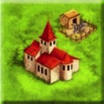

In [19]:
#View tree on each iteration - STEP 2 - Iterate

#By iteration
iterations = 700
def run_iteration(iterations):
    for it in range(iterations):
        mcts_agent.iteration()
run_iteration(iterations)
#cProfile.run("run_iteration(iterations)")

#By_choose_action
def run_choose_action():
    mcts_agent.max_iterations = iterations
    mcts_agent.choose_action(game_state)
#run_choose_action()

print("Iterations: ", mcts_agent.current_iterations)
print("FM calls: ", mcts_agent.current_fm)
print("Recommended action: ", mcts_agent.recommendation_policy())
print(mcts_agent.view_mcts_tree())
#print(mcts_agent.view_action_stats())
#print(mcts_agent.view_proven_tree())
Image("Games/Carcassonne/pygame_images/"+ str(game_state.next_tile_index)+".png")

In [ ]:
#Create color palette

color_palette = [ "#B10909" #red
                ,  "#5B8C5A"#green
                ,"#56638A" #blue-purple
                , "#EC7316" #orange
                ,  "#FC738C" ] #pink
color_palette = ["#5B8C5A"
                ,"#56638A"
                , "#EC7316"]
color_palette[2] = eu.color_rgb_to_hex(eu.darken_color(eu.color_hex_to_rgb(color_palette[2]), 0.4))
color_palette[0] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[0]), 0.3))
color_palette[1] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[1]), 0.1))

eu.view_color_palette(color_palette)

print("color_palette = {}".format(color_palette))

-----------FOP-------------

In [28]:
#General parameters
logs_path = os.path.join("Outputs","FO_single_decision_final")
data_order = [
        "MCTS_c0_5",
        "MCTS_c1",
        "MCTS_c1_4142",
        "MCTS_c2",
        "MCTS_c3",
        "EA_MCTS_its2570",
        "EA_MCTS_its5000",
        "SIEA_MCTS_its2570",
        "SIEA_MCTS_its5000",
        "SIEA2_its2570",
        "SIEA2_its5000",
        "SIEA2_MCTS_its2570",
        "SIEA2_MCTS_its5000"
    ]
data_order = data_order[::-1]
colors = ["#5B8C5A","#56638A","#EC7316","#e4c9db","#e4deb8","#e265ef","#c27dd1","#d52e87","#a8d0b9","#ad8dfd"]
name_replaces = {"SIEA2_MCTS_its2570": "EA_MCTS2_its2570", "SIEA2_MCTS_its5000": "EA_MCTS2_its5000"}

In [24]:
#Compile logs - needed only the first time!

for file_name in ["evolution_logs.csv", "results.csv", "logs_by_run.csv"]:
    file_path_list = lm.find_log_files(file_name, logs_path)
    lm.combine_logs(logs_path, file_name, file_path_list)

#Evolved formulas analysis
data = pd.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
evolved_formula_data = pd.DataFrame()
for agent in data["Player"].unique():
    if "EA" in agent:
        for f_index in data["Function_index"].unique():
            tdata = data[(data["Player"]==agent) & (data["Function_index"]==f_index)]
            fa_data = eu.evolved_formula_analysis(tdata)
            fa_data["Player"] = [agent]
            fa_data["Function_index"] = [f_index]
            evolved_formula_data = pd.concat([evolved_formula_data, fa_data])
evolved_formula_data.to_csv(os.path.join(logs_path, "evolved_formula_analysis.csv"))

In [ ]:
#Plot histograms

n_bins = 2**7
#logs_path = os.path.join("Outputs","FO_single_decision_final")
file_path_list = lm.find_log_files("tree_data.csv", logs_path)
print(["\n" + f for f in file_path_list])
for function_index in range(5):
  data_list = []
  subplot_titles = []
  file_paths = []

  #Add mcts vanilla
  #"""
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
      agent_name = file_path.split(os.sep)[-2]
      if "_c" in agent_name:
        data_list.append(pd.read_csv(file_path)) #mod to get interesting runs
        if "1_4142" in agent_name:
           agent_name= agent_name.replace("1_4142", "\u221A\u03052\u0305")
        if "0_5" in agent_name:
           agent_name= agent_name.replace("0_5", "0.5")
        agent_name = agent_name.replace("MCTS_", "MCTS ")
        agent_name = agent_name.replace(" c", " c = ")
        subplot_titles += [agent_name]
        file_paths += [file_path]
        paths_to_remove += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)
  #"""

  #add ea
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "EA_" in agent_name and not ("SIEA_" in agent_name or "SIEA2_" in agent_name):
      data_list.append(pd.read_csv(file_path))
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  #add siea
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]

  #add ea2
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA2_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      if agent_name in name_replaces.keys():
        agent_name = name_replaces[agent_name]
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      #if "SIEA2_MCTS" in agent_name:
      #  agent_name = agent_name.replace("SIEA2_MCTS", "EA_MCTS2")
      subplot_titles += [agent_name]
      file_paths += [file_path]
    
  if subplot_titles != [] and data_list != []:
    fop = fo.GameState(function_index=function_index)

    #print(len(data_list))
    """ #mod to get interesting runs
    interesting_runs = [0,10,16,36,41,45,72,73,97]
    interesting_data = []
    interesting_titles = ["Tunnel","Even","Random", "Exploratory", "Opposite", "Emergent 1", "Emergent 2", "Emergent 3", "UCB1 c=0.25"]
    interesting_titles = ["Behaviour type " + str(i) for i in range(len(interesting_runs))]
    for j in range(10):
      new_data_list = []
      subplot_titles = []
      dat = data_list[1]
      for i in range(j*10,(j+1)*10):
        tdat = dat.loc[dat["run"] == i]
        new_data_list = new_data_list + [tdat]
        if i==40:
          my_dat = tdat
        if i in interesting_runs:
          interesting_data += [tdat]
        subplot_titles += ["Run " + str(i)]
      subdata_list = new_data_list
    """
    print("plotting")
    plot = eu.fo_tree_histogram_average(data_list,  #mod to get interesting runs
                        fop.function, 
                        "F"+str(function_index+1) , #mod to get interesting runs
                        divisions = 3,
                        n_buckets = n_bins, 
                        subplot_titles = [""] + subplot_titles, #mod to get interesting runs
                        max_x_location=fop.max_location[0],
                        y_ref_value=None)
    #plot.write_image(os.path.join(logs_path, "Interesting_runs.png"))#"F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'))#, width=800, height=1000) 
    plot.write_image(os.path.join(logs_path, "F" + str(function_index+1) + "_results"+ str(n_bins) + '_all_agents.png'), width=800, height=1000) 
    #plot.show()
    #0,5,

In [13]:
#CP: FOP boxplot best reward path

#define variables
#logs_path = os.path.join("Outputs","FO_single_decision_4")
titles = ["Highest reward node-based result by MCTS variant", "Most visited node-based result by MCTS variant"]
boxplot_data = ["eval_of_max_reward_leaf_node", "eval_of_max_visits_leaf_node"]
assert len(titles) == len(boxplot_data), "Titles and boxplot_data must have the same length"

for i in range(len(titles)):
    logs = lm.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
    title_text = titles[i]
    y_columns = [boxplot_data[i]]
    plot_separation_column = "Function_index"
    x_column = "player_name"
    #sort dataset according to order:
    logs["player_name"] = pd.Categorical(logs["player_name"], data_order)
    logs = logs.sort_values("player_name")

    #change SIEA2_its2570 for EA2_its2570
    for name_replace in name_replaces.keys():
         logs["player_name"] = logs["player_name"].replace(name_replace, name_replaces[name_replace])
    #logs["player_name"] = logs["player_name"].replace("SIEA2_MCTS_its2570", "EA_MCTS2_its2570")
    #logs["player_name"] = logs["player_name"].replace("SIEA2_MCTS_its5000", "EA_MCTS2_its5000")

    #Calculate uniques
    plot_identifiers = logs[plot_separation_column].unique()
    #sort plot identifiers
    plot_identifiers = sorted(plot_identifiers, key=lambda x: x)
    #box_group_identifiers = logs[box_group_column].unique()
    print("plot_identifiers", plot_identifiers)
    #print("box_group_identifiers", box_group_identifiers)

    #Create figure
    n_rows = len(y_columns)
    fig = make_subplots(rows=n_rows
                            ,cols=len(plot_identifiers)
                            ,shared_xaxes=True
                            ,shared_yaxes=True
                            #,vertical_spacing=0.04
                            #,row_heights=[1/n_rows for _ in range(n_rows)]
                            ,subplot_titles = ["Function " + str(i+1) for i in plot_identifiers]*n_rows
                            #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                            ,x_title="Reward"
                            #,y_title='Max reward path'
                            #,print_grid=True
                            )

    for row, y_column in enumerate(y_columns):
        for col, plot_identifier in enumerate(plot_identifiers):
            #for group_id, box_group_identifier in enumerate(box_group_identifiers):
                data = logs[logs[plot_separation_column] == plot_identifier]
                #data = data[data[box_group_column] == box_group_identifier]
            
                fig.add_trace(go.Box(x=data[y_column]#[0 for _ in range(len(data))]#data[x_column]
                                    ,y=data[x_column]
                                    #,name=str(box_group_identifier)
                                    , width=0.9
                                    ,showlegend=False#row==0
                                    #,legendgroup=str(box_group_identifier)
                                    ,orientation = "h"
                                    , marker={"color":colors[1]}
                                    )
                                ,row=row + 1
                                ,col=col + 1)

    fig.update_layout(margin=dict(l=70, r=10, t=70, b=50)
                            ,width=1000
                            ,height=400
                            ,plot_bgcolor='rgba(0,0,0,0)'
                            #,plot_bgcolor="lightgray"
                            #,boxmode='group'
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,legend=dict(
                                title = "Rewards by MCTS variant"
                                ,orientation="h"
                                ,yanchor="top"
                                ,y=-0.075
                                ,xanchor="center"
                                ,x=0.4
                                ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                                ,font = dict(family = "Arial", size = 14, color = "black")
                                ,bordercolor="Black"
                                ,borderwidth=2
                                ,itemsizing='trace'
                                ,itemwidth = 30
                                ) 
                            )
    fig.update_layout(boxmode='group')
    fig.update_xaxes(showline=True
                            , linewidth=2
                            , linecolor='black'
                            , mirror=True
                            ,showgrid=True
                            , gridcolor="black"
                            , gridwidth=0.15
                            #, nticks=5
                            ,tickmode = 'linear'
                            ,tick0 = 0
                            , dtick=0.25
                            ,range= [0,1]
                            )

    fig.update_yaxes(showline=True
                        ,mirror=True
                        , linewidth=2
                        , linecolor='black'
                        )
    #give title to the plot
    fig.update_layout(title_text=title_text)

    fig.write_image(os.path.join(logs_path, title_text.replace(" ", "_").replace("-","_")+".png"))
    fig.show()


plot_identifiers [0, 1, 2, 3, 4]


plot_identifiers [0, 1, 2, 3, 4]


In [14]:
#CP: FOP boxplot best reward path

#define variables
#logs_path = os.path.join("Outputs","FO_single_decision_4")
logs = lm.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
y_columns = ["eval_of_max_reward_leaf_node", "eval_of_max_visits_leaf_node"] #this controls the groups
group_names = ["Highest reward node-based reward", "Most visited node-based reward"]
xaxis_name = "Reward"
title_text = "Optimal play reward by MCTS variant"
plot_separation_column = "Function_index"
#box_group_column = "player_name"
x_column = "player_name"#"current_iterations"#"pg_game_turn"
#sort dataset according to order:
logs["player_name"] = pd.Categorical(logs["player_name"], data_order)
logs = logs.sort_values("player_name")

#change SIEA2_its2570 for EA2_its2570
for name_replace in name_replaces.keys():
         logs["player_name"] = logs["player_name"].replace(name_replace, name_replaces[name_replace])

#Calculate uniques
plot_identifiers = logs[plot_separation_column].unique()
#sort plot identifiers
plot_identifiers = sorted(plot_identifiers, key=lambda x: x)
#box_group_identifiers = logs[box_group_column].unique()
colors = ["#5B8C5A","#56638A","#EC7316","#e4c9db","#e4deb8","#e265ef","#c27dd1","#d52e87","#a8d0b9","#ad8dfd"]
print("plot_identifiers", plot_identifiers)

#Create figure
n_rows = 1
fig = make_subplots(rows=n_rows
                        ,cols=len(plot_identifiers)
                        ,shared_xaxes=True
                        ,shared_yaxes=True
                        #,vertical_spacing=0.04
                        #,row_heights=[1/n_rows for _ in range(n_rows)]
                        ,subplot_titles = ["Function " + str(i+1) for i in plot_identifiers]*n_rows
                        #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                        ,x_title="Reward"
                        #,y_title='Max reward path'
                        #,print_grid=True
                        )

for y_i, y_column in enumerate(y_columns):
    for col, plot_identifier in enumerate(plot_identifiers):
        #for group_id, box_group_identifier in enumerate(box_group_identifiers):
            data = logs[logs[plot_separation_column] == plot_identifier]
            #data = data[data[box_group_column] == box_group_identifier]
        
                
            fig.add_trace(go.Box(x=data[y_column]#[0 for _ in range(len(data))]#data[x_column]
                                ,y=data[x_column]
                                ,name=group_names[y_i]
                                ,whiskerwidth=1
                                #,marker_size=5
                                #,line_width=1
                                , width=0.8
                                ,showlegend=col==0
                                ,opacity=0.8
                                #,legendgroup=str(box_group_identifier)
                                ,orientation = "h"
                                , marker={"color":colors[y_i]}
                                )
                            ,row=1
                            ,col=col + 1)

fig.update_layout(margin=dict(l=70, r=10, t=70, b=100)
                        ,width=1000
                        ,height=400
                        ,plot_bgcolor='rgba(0,0,0,0)'
                        #,plot_bgcolor="lightgray"
                        #,boxmode='group'
                        ,font = dict(family = "Arial", size = 14, color = "black")
                        ,legend=dict(
                            title = "Rewards by MCTS variant"
                            ,orientation="h"
                            ,yanchor="top"
                            ,y=-0.250
                            ,xanchor="center"
                            ,x=0.4
                            ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,bordercolor="Black"
                            ,borderwidth=2
                            ,itemsizing='trace'
                            ,itemwidth = 30
                            ) 
                        )
fig.update_xaxes(showline=True
                        , linewidth=2
                        , linecolor='black'
                        , mirror=True
                        ,showgrid=True
                        , gridcolor="black"
                        , gridwidth=0.15
                        #, nticks=5
                        ,tickmode = 'linear'
                        ,tick0 = 0
                        , dtick=0.25
                        ,range= [0,1]
                        )
fig.update_yaxes(showline=True
                    ,mirror=True
                    , linewidth=2
                    , linecolor='black'
                    )
#give title to the plot
fig.update_layout(title_text=title_text)
fig.update_layout(boxmode='group'
                  #,width=0.4
                #,boxgroupgap = 0
                #,boxgap = 0.1
                )
fig.write_image(os.path.join(logs_path, title_text.replace(" ", "_").replace("-","_")+".png"))
fig.show()

plot_identifiers [0, 1, 2, 3, 4]


In [16]:
#LEAF NODES DEPTHS

#CP: FOP boxplot best reward path
#define variables
#logs_path = os.path.join("Outputs","FO_single_decision_4")
titles = ["Average leaf node depth by MCTS variant", "Average leaf node count by MCTS variant"]
boxplot_data = ["avg_leaf_node_depth", "leaf_node_count"]
xaxis_name = ["Average leaf node depth", "Leaf node count"]
dticks = [2, 1000]
assert len(titles) == len(boxplot_data), "Titles and boxplot_data must have the same length"

for i in range(len(titles)):
    logs = lm.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
    title_text = titles[i]
    y_columns = [boxplot_data[i]]

    plot_separation_column = "Function_index"
    x_column = "player_name"#"current_iterations"#"pg_game_turn"
    #sort dataset according to order:
    logs["player_name"] = pd.Categorical(logs["player_name"], data_order)
    logs = logs.sort_values("player_name")

    #change SIEA2_its2570 for EA2_its2570
    for name_replace in name_replaces.keys():
         logs["player_name"] = logs["player_name"].replace(name_replace, name_replaces[name_replace])

    #Calculate uniques
    plot_identifiers = logs[plot_separation_column].unique()
    #sort plot identifiers
    plot_identifiers = sorted(plot_identifiers, key=lambda x: x)
    #box_group_identifiers = logs[box_group_column].unique()
    print("plot_identifiers", plot_identifiers)
    #print("box_group_identifiers", box_group_identifiers)

    #Create figure
    n_rows = len(y_columns)
    
    fig = make_subplots(rows=n_rows
                            ,cols=len(plot_identifiers)
                            ,shared_xaxes=True
                            ,shared_yaxes=True
                            #,vertical_spacing=0.04
                            #,row_heights=[1/n_rows for _ in range(n_rows)]
                            ,subplot_titles = ["Function " + str(i) for i in plot_identifiers]*n_rows
                            #, specs=[[{"secondary_y": True}] for _ in range(n_plots+1)]
                            ,x_title=xaxis_name[i]
                            #,y_title='Max reward path'
                            #,print_grid=True
                            )

    for row, y_column in enumerate(y_columns):
        for col, plot_identifier in enumerate(plot_identifiers):
            #for group_id, box_group_identifier in enumerate(box_group_identifiers):
                data = logs[logs[plot_separation_column] == plot_identifier]
                #data = data[data[box_group_column] == box_group_identifier]
            
                #print(data[x_column].unique())
                fig.add_trace(go.Box(x=data[y_column]#[0 for _ in range(len(data))]#data[x_column]
                                    ,y=data[x_column]
                                    #,name=str(box_group_identifier)
                                    , width=0.9
                                    ,showlegend=False#row==0
                                    #,legendgroup=str(box_group_identifier)
                                    ,orientation = "h"
                                    , marker={"color":colors[1]}
                                    )
                                ,row=row + 1
                                ,col=col + 1)

    fig.update_layout(margin=dict(l=70, r=10, t=70, b=50)
                            ,width=1000
                            ,height=400
                            ,plot_bgcolor='rgba(0,0,0,0)'
                            #,plot_bgcolor="lightgray"
                            #,boxmode='group'
                            ,font = dict(family = "Arial", size = 14, color = "black")
                            ,legend=dict(
                                title = "Rewards by MCTS variant"
                                ,orientation="h"
                                ,yanchor="top"
                                ,y=-0.075
                                ,xanchor="center"
                                ,x=0.4
                                ,bgcolor="white"#"lightgray"#"rgba(200, 255, 255, 0.8)"
                                ,font = dict(family = "Arial", size = 14, color = "black")
                                ,bordercolor="Black"
                                ,borderwidth=2
                                ,itemsizing='trace'
                                ,itemwidth = 30
                                ) 
                            )
    fig.update_layout(boxmode='group')
    fig.update_xaxes(showline=True
                            , linewidth=2
                            , linecolor='black'
                            , mirror=True
                            ,showgrid=True
                            , gridcolor="black"
                            , gridwidth=0.15
                            #, nticks=5
                            #,tickmode = 'linear'
                            , tick0 = 0
                            , dtick=dticks[i]
                            #,range= [0,1]
                            )

    fig.update_yaxes(showline=True
                        ,mirror=True
                        , linewidth=2
                        , linecolor='black'
                        )
    #give title to the plot
    fig.update_layout(title_text=title_text)

    fig.write_image(os.path.join(logs_path, title_text.replace(" ", "_").replace("-","_")+".png"))
    fig.show()


plot_identifiers [0, 1, 2, 3, 4]


plot_identifiers [0, 1, 2, 3, 4]


In [1]:
#LUDO

class LudoArrow():
    def __init__(self,  end_index=None, player_house=None):
        self.player_house = player_house #The player whose house this is
        self.end_index = end_index

class LudoSquare():
    def __init__(self, index, is_safe=False, arrow=None, content=None, next_square_index=None, player_house=None, is_victory_path=False):
        self.index = index
        self.is_safe = is_safe
        self.content = content #A list of pieces
        self.next_square_index = next_square_index #The index of the next square
        self.player_house = player_house #The player whose house this sends to
        self.is_victory_path = is_victory_path #Whether this is a victory path square

class LudoPiece():
    def __init__(self, index, player):
        self.index = index
        self.player = player
        
class GameState():
    def __init__(self, n_players, pieces_per_player=4):
        self.players = ["red", "green", "blue", "yellow"]
        self.n_players = n_players
        self.pieces_per_player = pieces_per_player
    def set_initial_state(self):
        self.board = {}
        self.players_houses = {12:"red", 25:"green", 38:"blue", 51:"yellow"}
        self.players_starting_index = {"red":15, "green":28, "blue":41, "yellow":2}
        for i in range(52):
            if i in [2, 10, 15, 23, 28, 36, 41, 49]: #safe squares
                square = LudoSquare(i, is_safe=True)
            elif i in [6, 19, 32, 45]: #squares with immediate arrows
                arrow = LudoArrow(end_index=i+1)
                square = LudoSquare(i, arrow=arrow)
            elif i in [10, 23, 36, 49]: #squares with arrows to the player houses
                arrow = LudoArrow(end_index=53, player_house=i)
                square = LudoSquare(i, arrow=arrow)
            elif i in [13, 26, 39, 52]:
                square = LudoSquare(i, player_house=self.players_houses[i])







In [ ]:
#LORCANA API
import requests
import json
import pandas as pd

names_request = requests.get('https://api.lorcana-api.com/lists/names')
if names_request.status_code == 200:
    response_string = str(names_request.content).split("\\n")
print("Got ", str(len(response_string)), " names from the API")

names = []
card_dataset = []
failed_cards = []
for raw_name in response_string:
    card_data = None
    attempts = 0
    while attempts < 5:
        if "," in raw_name: #Filtering for missing cards
            name = raw_name.replace("\"", "")
            name = name.replace("\\", "")
            name = name.replace(" ", "")
            name = name.replace(",", "")

            full_string = 'https://api.lorcana-api.com/strict/' + name
            print("Trying string: ", full_string)
            #print(full_string)
            card_data = requests.get(full_string)
            if card_data.status_code == 200:
                print(card_data.content)
                break
            else:
                print('Request failed with status code:', card_data.status_code)
                card_data = None
                attempts += 1
        else:
            print("Skipping: ", raw_name)
            break
        
    #Save the data in a dictionary
    if card_data is not None:
        card_dict = json.loads(card_data.content)
        card_dataset.append(card_dict)
    else:
        failed_cards.append(raw_name)
        print("Failed to get data for: ", raw_name)
    
#Merge all the dicionaries in a single dataframe
df = pd.DataFrame()
for card_dict in card_dataset:
    #card_df = pd.DataFrame(card_dict, index = [0])
    card_df = pd.DataFrame()
    for key,value in card_dict.items():
        print(key, value)
        card_df[key] = [value]
    df = pd.concat([df, card_df], axis = 0)
    #Save df to csv
    df.to_csv("card_data.csv", index = False)